## Performance of `torch.index_copy_`

Note: this notebook requires one of:

- JAX nightly 2025 Jun 10 or before
- JAX nightly 2025 Jun 30 or after

To run successfully, due to certain cloud-side libtpu regression.

In [1]:
import os
os.environ['LIBTPU_INIT_ARGS']='--xla_tpu_scoped_vmem_limit_kib=98304 --xla_tpu_use_minor_sharding_for_major_trivial_input=true --xla_tpu_relayout_group_size_threshold_for_reduce_scatter=1 --xla_tpu_assign_all_reduce_scatter_layout=true --xla_tpu_enable_data_parallel_all_reduce_opt=true --xla_tpu_data_parallel_opt_different_sized_ops=true --xla_tpu_enable_async_collective_fusion=true --xla_tpu_enable_async_collective_fusion_fuse_all_gather=true --xla_tpu_enable_async_collective_fusion_multiple_steps=true  --xla_tpu_overlap_compute_collective_tc=true  --xla_enable_async_all_gather=true --xla_tpu_enable_async_collective_fusion_fuse_all_reduce=false  --xla_tpu_enable_sparse_core_collective_offload_all_reduce=true --xla_tpu_use_tc_device_shape_on_sc=true  --xla_sc_disable_megacore_partitioning=true  --2a886c8_chip_config_name=megachip_tccontrol'

import torch_xla

print(torch_xla.devices())

/workspaces/torch/pytorch/xla/torch_xla/__init__.py:258: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(


[device(type='xla', index=0), device(type='xla', index=1), device(type='xla', index=2), device(type='xla', index=3), device(type='xla', index=4), device(type='xla', index=5), device(type='xla', index=6), device(type='xla', index=7)]


`torch.index_copy_` is used in vLLM pallas attention layers to copy the key and
value vectors generated during the forward pass of one scheduling step into the
KV cache.

```py
def write_to_kv_cache(
    key: torch.Tensor,
    value: torch.Tensor,
    kv_cache: torch.Tensor,
    slot_mapping: torch.Tensor,
) -> None:
    """Write the key and values to the KV cache.

    Args:
        key: shape = [num_tokens, num_kv_heads * head_size]
        value: shape = [num_tokens, num_kv_heads *  head_size]
        kv_cache = [num_blocks, block_size, num_kv_heads * 2, head_size]
        slot_mapping = [num_tokens]

    """
    _, _, num_combined_kv_heads, head_size = kv_cache.shape
    head_size = cdiv(head_size,
                     TPU_HEAD_SIZE_ALIGNMENT) * TPU_HEAD_SIZE_ALIGNMENT
    kv = torch.cat([key, value], axis=-1).reshape(-1, num_combined_kv_heads,
                                                  head_size)

    torch.ops.xla.dynamo_set_buffer_donor_(kv_cache, True)

    kv_cache = kv_cache.flatten(0, 1)
    kv_cache.index_copy_(0, slot_mapping, kv)
```

`slot_mapping` might look like:

```py
torch.Size([16]) tensor([64, 65, 66, 67, 68, 69, 70, 71, 72, 1000000000, 1000000000, ...])
```

which indicates a light prefill step involving 9 valid tokens, or

```py
torch.Size([256]) tensor([73, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140,
                          192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203,
                          256, 257, 258, 259, 260, 261, 262, 263, 264, 265, ...])
```

which indicates a heavy mixed prefill and decode step processing 256 tokens, or

```py
torch.Size([16]) tensor([74, 141, 204, 485, 1000000000, 1000000000, ...])
```

which indicates a light decode step generating 4 new tokens for 4 requests, etc.

`1000000000` is an out-of-bounds sentinel value that indicates that particular
token slot is unused.

In `google/gemma-3-27b-it` over 8 chips via tensor parallelism, the KV cache has
a shape of `bf16[5607,64,4,128]` (flattened to `bf16[358848,4,128]`). Gemma 3 has
16+16=32 KV heads but that's sharded over 8 chips, so each chip stores 4 heads.

In vLLM TPU, each scheduling step appears to process 16 to 256 tokens. We will
now benchmark the HBM throughput of a scattered copy of 256 tokens on a v6e chip.

In [2]:
import numpy as np
import torch
import torch_xla.core.xla_model as xm
import torch_xla.debug.profiler as xp
from xprof_step_time.step_duration import step_duration_from_latest_profile

def index_copy(kv_cache, new_kv, slot_mapping):
  assert new_kv.shape[0] == slot_mapping.shape[0]
  assert new_kv.shape[1:] == kv_cache.shape[2:]
  torch.ops.xla.dynamo_set_buffer_donor_(kv_cache, True)
  kv_cache.flatten(0, 1).index_copy_(0, slot_mapping, new_kv)

@torch.compile(backend='openxla')
def benchmark_step(kv_cache, new_kv, slot_mapping):
  index_copy(kv_cache, new_kv, slot_mapping)

def benchmark_index_copy(num_heads=4):
  # Create a slot mapping of size 256.
  slot_mapping = torch.from_numpy(np.arange(256, dtype=np.uint32)).long().to('xla')

  # Create a KV cache with 5607 blocks, each with 64 token slots.
  BLOCK_SIZE = 64
  HEAD_SIZE = 128
  kv_cache = torch.rand((5607, BLOCK_SIZE, num_heads, HEAD_SIZE), dtype=torch.bfloat16).to('xla')

  # Benchmark index_copy performance.
  new_kv = torch.rand((256, num_heads, HEAD_SIZE), dtype=torch.bfloat16).to('xla')

  # Warm up
  def run_warmup():
    for i in range(2):
      benchmark_step(kv_cache, new_kv, slot_mapping)
      torch_xla.sync(wait=True)
      xm.wait_device_ops()

  run_warmup()

  # Benchmark
  PROFILE_DIR = 'profile/index_copy'
  os.makedirs(PROFILE_DIR, exist_ok=True)

  def run_benchmark():
    torch_xla.sync(wait=True)
    xm.wait_device_ops()
    NUM_STEPS = 200
    xp.start_trace(PROFILE_DIR)
    for i in range(NUM_STEPS):
      benchmark_step(kv_cache, new_kv, slot_mapping)
    torch_xla.sync(wait=True)
    xm.wait_device_ops()
    xp.stop_trace()
    step_time = step_duration_from_latest_profile(PROFILE_DIR, ignore_gaps=True, verbose=False)
    bytes_copied = new_kv.numel() * new_kv.element_size()
    print(f"Execution took {step_time * 1000:.4f} ms. Bytes copied: {bytes_copied} bytes.")
    throughput = bytes_copied / step_time
    print(f"Throughput: {throughput / 1e9:.2f} GB/s.")
    return throughput

  return run_benchmark()

throughput_4 = benchmark_index_copy(num_heads=4)

Execution took 0.0235 ms. Bytes copied: 262144 bytes.
Throughput: 11.15 GB/s.


Let's try hypothetical scenarios with more KV heads.

In [3]:
throughputs = [throughput_4]
num_heads = [4]
for num_head in [8, 16, 32, 64]:
  print(f"Benchmarking with {num_head} heads...")
  throughput = benchmark_index_copy(num_heads=num_head)
  throughputs.append(throughput)
  num_heads.append(num_head)

num_heads = np.array(num_heads)
throughputs = np.array(throughputs) / 1e9  # Convert to GB/s

Benchmarking with 8 heads...
Execution took 0.0237 ms. Bytes copied: 524288 bytes.
Throughput: 22.08 GB/s.
Benchmarking with 16 heads...
Execution took 0.0266 ms. Bytes copied: 1048576 bytes.
Throughput: 39.38 GB/s.
Benchmarking with 32 heads...
Execution took 0.0287 ms. Bytes copied: 2097152 bytes.
Throughput: 72.97 GB/s.
Benchmarking with 64 heads...
Execution took 0.0323 ms. Bytes copied: 4194304 bytes.
Throughput: 129.98 GB/s.


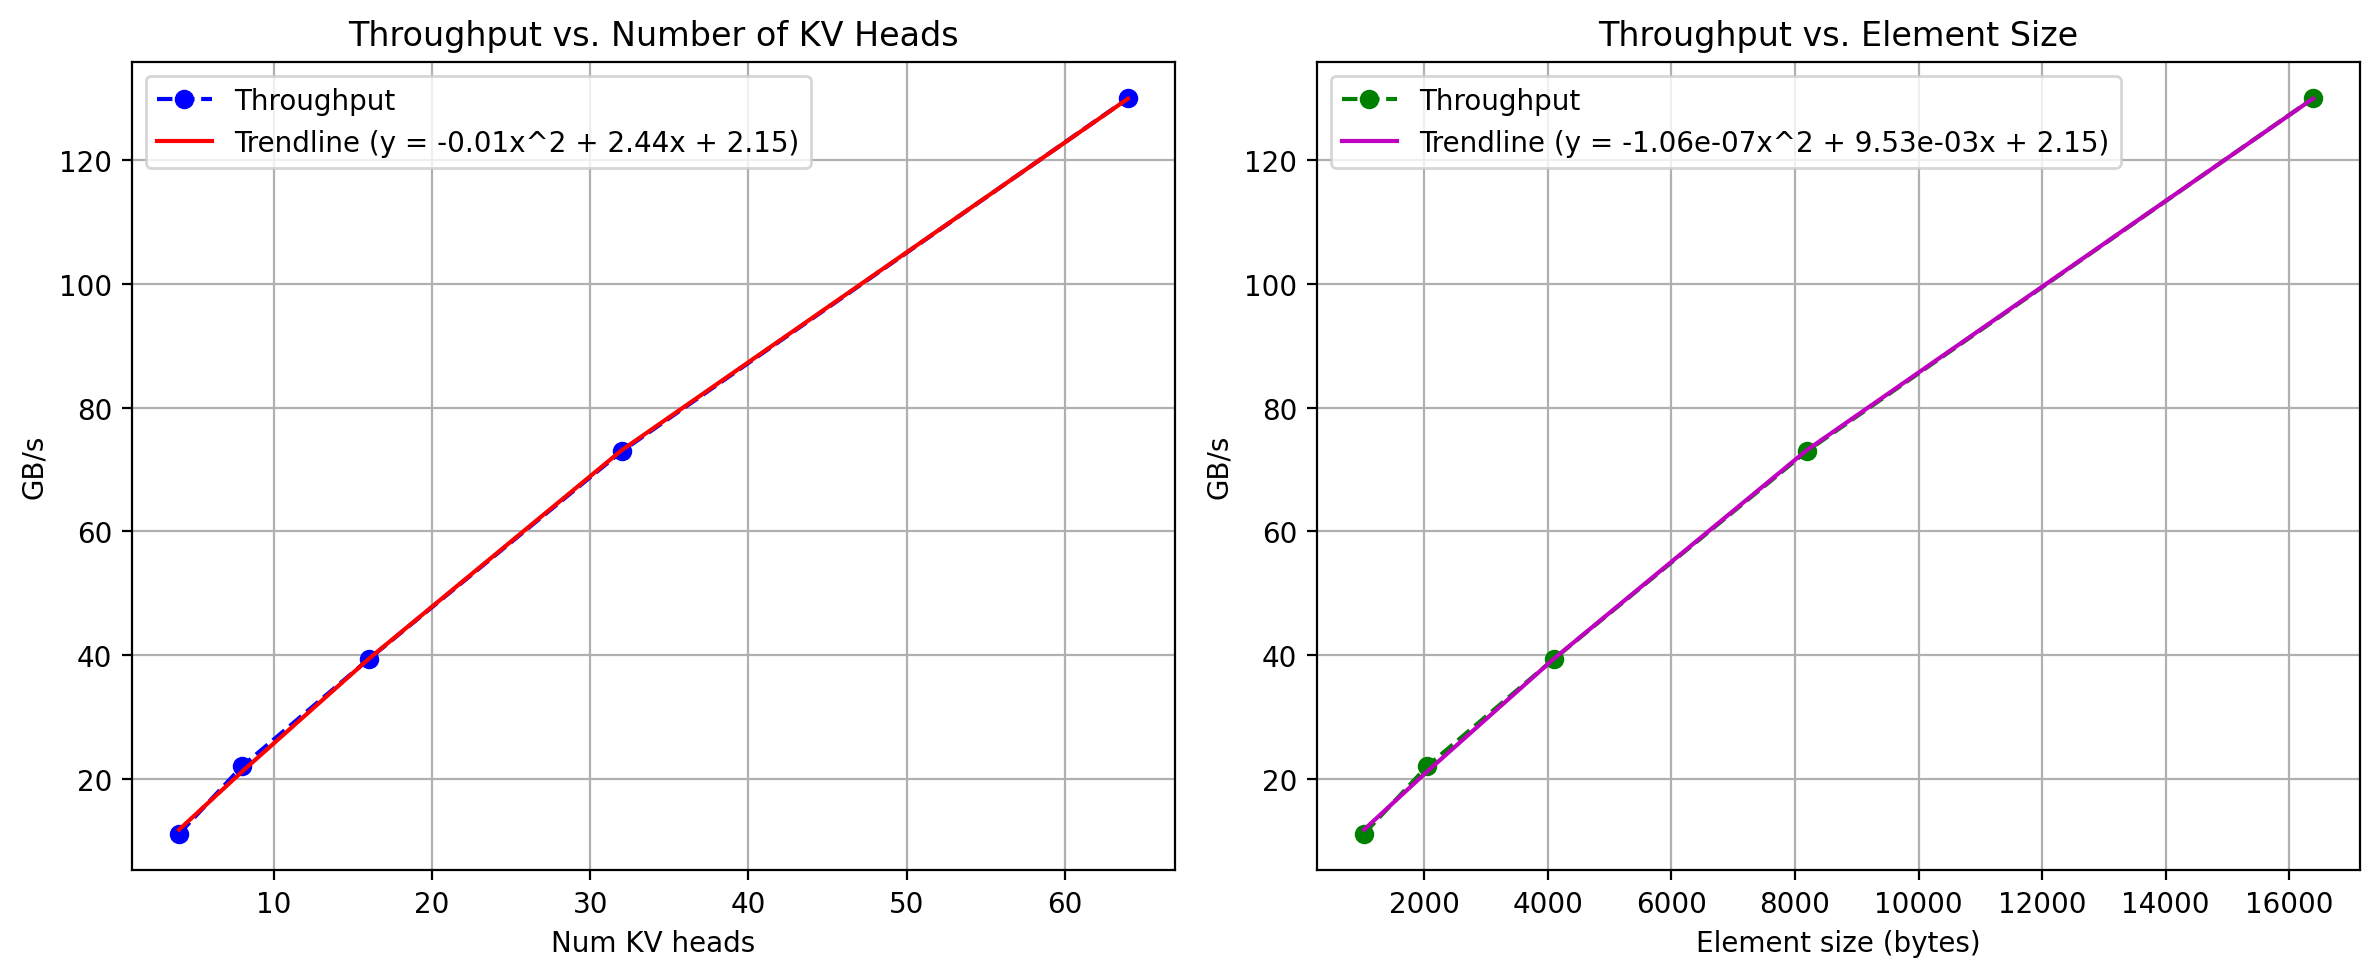

In [4]:
import numpy as np
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# --- First subplot: Throughput vs. Number of KV Heads ---
coeffs1 = np.polyfit(num_heads, throughputs, 2)
fitted1 = np.poly1d(coeffs1)
ax1.plot(num_heads, throughputs, 'bo--', label='Throughput')
ax1.plot(num_heads, fitted1(num_heads), 'r-', label=f'Trendline (y = {coeffs1[0]:.2f}x^2 + {coeffs1[1]:.2f}x + {coeffs1[2]:.2f})')
ax1.set_title('Throughput vs. Number of KV Heads')
ax1.set_ylabel('GB/s')
ax1.set_xlabel('Num KV heads')
ax1.legend()
ax1.grid(True)

# --- Second subplot: Throughput vs. Element Size ---
element_size = num_heads * 128 * 2  # in bytes

coeffs2 = np.polyfit(element_size, throughputs, 2)
fitted2 = np.poly1d(coeffs2)
ax2.plot(element_size, throughputs, 'go--', label='Throughput')
# Using scientific notation for coefficients as they can be very small
ax2.plot(element_size, fitted2(element_size), 'm-', label=f'Trendline (y = {coeffs2[0]:.2e}x^2 + {coeffs2[1]:.2e}x + {coeffs2[2]:.2f})')
ax2.set_title('Throughput vs. Element Size')
ax2.set_ylabel('GB/s')
ax2.set_xlabel('Element size (bytes)')
ax2.legend()
ax2.grid(True)

# Adjust layout to prevent titles/labels from overlapping and show the plot
plt.tight_layout()
plt.show()

## Observations

The `index_copy_` operation is lowered to an XLA `scatter` operation.

![index copy hlo](./index-copy-hlo.png)

We're not sure how `scatter` is implemented. However, it's clear that throughput
suffers when each element to be scattered is small. When copying `bf16[4, 128]`
elements, the throughput is only 11 GB/s. Throughput more or less scales linearly
with element size, modulo a small `-0.01x^2` overhead factor. For every KB of
scatter element size increase, throughput increases by 9.6 GB.

For reference, v6e HBM bandwidth is 1640 GB/s. Even considering that `scatter`
might be reading `new_kv` into VMEM and then writing it back to HBM, thus
generating twice the traffic, we are still far from hitting peak HBM bandwidth.

## Prototype faster copy

Let's create a toy Pallas kernel that copies the key value vectors for multiple
elements in one program instance, and see how fast it can be.

In [5]:
import jax
import jax.numpy as jnp
from jax.experimental import pallas as pallas
import numpy as np
import gc

NUM_HEADS = 4

def copy_kernel(x_ref, y_ref):
  y_ref[...] = x_ref[...]

def pallas_copy(x: jax.Array, copy_num_tokens: int, num_heads: int, debug: bool) -> jax.Array:
  out_shape = jax.ShapeDtypeStruct(x.shape, x.dtype)
  spec = pallas.BlockSpec((copy_num_tokens, num_heads, 128,), lambda i: (i, 0, 0))

  y = pallas.pallas_call(
      copy_kernel,
      out_shape=out_shape,
      grid=(x.shape[0] // copy_num_tokens,),
      in_specs=[spec],
      out_specs=spec,
      debug=debug,
  )(x)
  return y


# Create some test data
array_size = (256, NUM_HEADS, 128)
x_device = jnp.arange(np.prod(array_size), dtype=jnp.bfloat16).reshape(array_size)

jitted_pallas_copy = jax.jit(pallas_copy, static_argnames=('copy_num_tokens', 'num_heads', 'debug'))
y_device = jitted_pallas_copy(x_device, copy_num_tokens=128, num_heads=NUM_HEADS, debug=True)

# Verify the result
print(f"Input and output arrays are close: {jnp.allclose(x_device, y_device)}")
print(f"Input shape: {x_device.shape}, Output shape: {y_device.shape}")
print(f"Input dtype: {x_device.dtype}, Output dtype: {y_device.dtype}")


# Benchmark the performance
def run_benchmark(copy_num_tokens=128):
  gc.collect()
  all_outputs = []
  jax.block_until_ready(jax.live_arrays())
  NUM_STEPS = 200
  PROFILE_DIR = 'profile/index_copy_pallas'
  os.makedirs(PROFILE_DIR, exist_ok=True)
  jax.profiler.start_trace(PROFILE_DIR)
  for i in range(NUM_STEPS):
    all_outputs.append(jitted_pallas_copy(x_device, copy_num_tokens=copy_num_tokens, num_heads=NUM_HEADS, debug=False))
  jax.block_until_ready(all_outputs)
  jax.profiler.stop_trace()
  step_time = step_duration_from_latest_profile(PROFILE_DIR, ignore_gaps=True, verbose=False)
  bytes_copied = all_outputs[-1].size * all_outputs[-1].dtype.itemsize
  print(f"Execution took {step_time * 1000:.4f} ms. Bytes copied: {bytes_copied} bytes.")
  throughput = bytes_copied / step_time
  print(f"Throughput: {throughput / 1e9:.2f} GB/s.")
  return throughput

toy_pallas_num_tokens = [1, 2, 4, 8, 16, 32, 64, 128]
toy_pallas_throughput = []
for copy_num_tokens in toy_pallas_num_tokens:
  print(f"Running benchmark with copy_num_tokens={copy_num_tokens}...")
  throughput = run_benchmark(copy_num_tokens=copy_num_tokens)
  toy_pallas_throughput.append(throughput / 1e9)  # Convert to GB/s
  gc.collect()


The kernel jaxpr for pallas_call copy_kernel at /tmp/ipykernel_424140/405746441.py:9:
{ lambda ; a:MemRef<None>{bfloat16[128,4,128]} b:MemRef<None>{bfloat16[128,4,128]}. let
    c:bf16[128,4,128] <- a[:,:,:]
    b[:,:,:] <- c
  in () }

The Mosaic module for pallas_call copy_kernel at /tmp/ipykernel_424140/405746441.py:9:
module @copy_kernel {
  func.func @main(%arg0: i32, %arg1: memref<128x4x128xbf16, #tpu.memory_space<vmem>>, %arg2: memref<128x4x128xbf16, #tpu.memory_space<vmem>>) attributes {dimension_semantics = [#tpu.dimension_semantics<arbitrary>], iteration_bounds = array<i64: 2>, scalar_prefetch = 0 : i64, scratch_operands = 0 : i64, window_params = [{transform_indices = @transform_0, window_bounds = array<i64: 128, 4, 128>}, {transform_indices = @transform_1, window_bounds = array<i64: 128, 4, 128>}]} {
    %c0 = arith.constant 0 : index
    %c0_0 = arith.constant 0 : index
    %c0_1 = arith.constant 0 : index
    %0 = vector.load %arg1[%c0, %c0_0, %c0_1] : memref<128x4x128xb

2025-06-25 05:58:34.739609: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750831114.748844  424140 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750831114.751586  424140 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750831114.762012  424140 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750831114.762026  424140 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750831114.762028  424140 computation_placer.cc:177] computation placer alr

Execution took 0.0817 ms. Bytes copied: 262144 bytes.
Throughput: 3.21 GB/s.
Running benchmark with copy_num_tokens=2...
Execution took 0.0426 ms. Bytes copied: 262144 bytes.
Throughput: 6.15 GB/s.
Running benchmark with copy_num_tokens=4...
Execution took 0.0224 ms. Bytes copied: 262144 bytes.
Throughput: 11.73 GB/s.
Running benchmark with copy_num_tokens=8...
Execution took 0.0118 ms. Bytes copied: 262144 bytes.
Throughput: 22.18 GB/s.
Running benchmark with copy_num_tokens=16...
Execution took 0.0066 ms. Bytes copied: 262144 bytes.
Throughput: 39.85 GB/s.
Running benchmark with copy_num_tokens=32...
Execution took 0.0037 ms. Bytes copied: 262144 bytes.
Throughput: 70.37 GB/s.
Running benchmark with copy_num_tokens=64...
Execution took 0.0025 ms. Bytes copied: 262144 bytes.
Throughput: 106.16 GB/s.
Running benchmark with copy_num_tokens=128...
Execution took 0.0015 ms. Bytes copied: 262144 bytes.
Throughput: 172.75 GB/s.


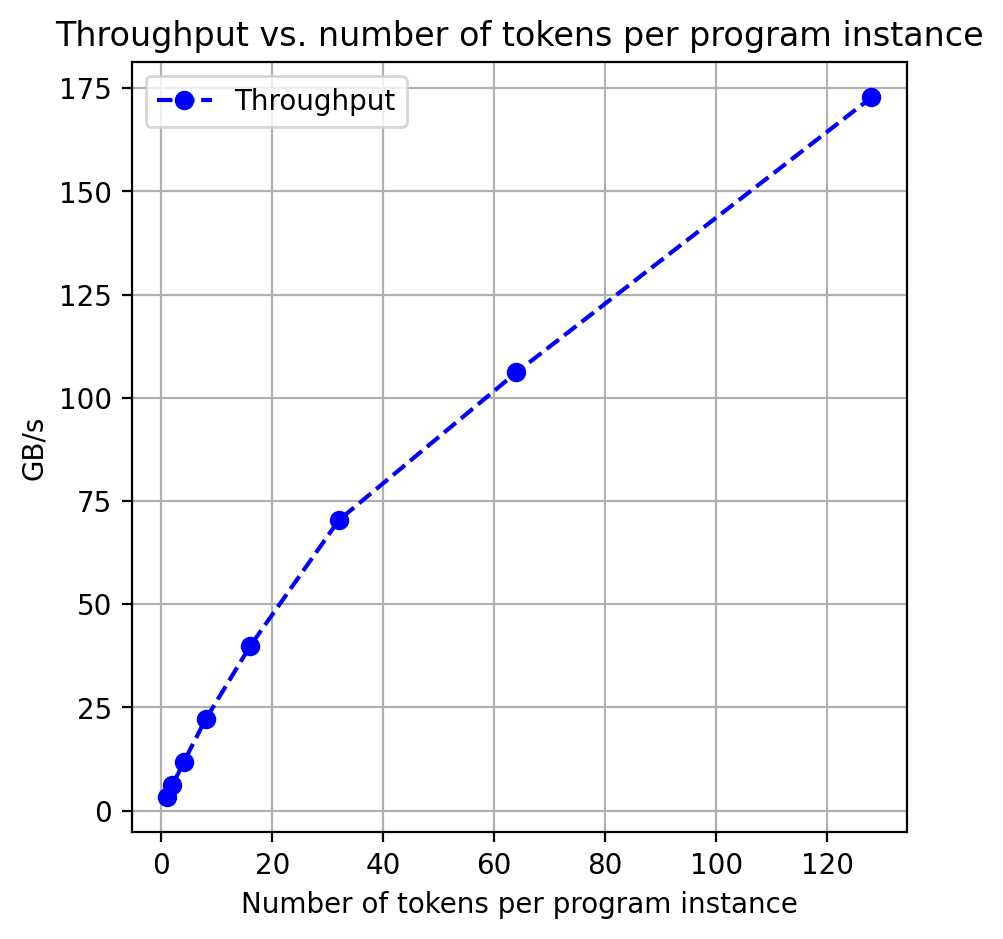

In [6]:
import numpy as np
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

fig, ax1 = plt.subplots(1, 1, figsize=(5, 5))

ax1.plot(toy_pallas_num_tokens, toy_pallas_throughput, 'bo--', label='Throughput')
ax1.set_title('Throughput vs. number of tokens per program instance')
ax1.set_ylabel('GB/s')
ax1.set_xlabel('Number of tokens per program instance')
ax1.legend()
ax1.grid(True)

That confirms that in the ideal case, we can easily beat `scatter` throughput
with up to 15x speedup.

Now the tricky part is figuring out how to dynamically exploit the contiguity
in the slot mapping in case of prefill, while still handling the discontiguous
slot indices in case of decode.

## Asynchronous HBM copy

Can we start 256 asynchronous DMAs, each handling the KV for one token?

This will potentially let us copy each token to a different location, depending
on the slot mapping.

In [7]:
from typing import Any
from jax.experimental import pallas as pl
from jax.experimental.pallas import tpu as pltpu

Future = Any

def make_async_copy(target_memory_space=pltpu.ANY, copy_num_tokens: int=1):
  @jax.named_call
  def async_copy_start(x: jax.Array) -> tuple[jax.Array, Future]:

    def copy_start_kernel(x_ref, aliased_x_ref, o_ref, sem):
      del aliased_x_ref
      pltpu.make_async_copy(x_ref.at[pl.program_id(0)], o_ref.at[pl.program_id(0)], sem.at[0]).start()

    x, out, sem = pl.pallas_call(
        copy_start_kernel,
        out_shape=(
            jax.ShapeDtypeStruct(x.shape, x.dtype),  # aliased x
            target_memory_space(x.shape, x.dtype),  # out
            pltpu.SemaphoreType.DMA((x.shape[0] // copy_num_tokens,)),  # sem
        ),
        grid=(x.shape[0] // copy_num_tokens,),
        in_specs=[
            pl.BlockSpec(memory_space=pltpu.ANY),
        ],
        out_specs=(
            pl.BlockSpec(memory_space=pltpu.ANY),
            pl.BlockSpec(memory_space=target_memory_space),
            pl.BlockSpec((1,), lambda i: (i,), memory_space=pltpu.SEMAPHORE),
        ),
        input_output_aliases={0: 0},
    )(x)
    return x, (out, sem)

  @jax.named_call
  def async_copy_done(x: jax.Array, future: Future) -> jax.Array:
    out, sem = future

    def copy_done_kernel(x_ref, o_ref, sem, aliased_o_ref):
      del aliased_o_ref
      pltpu.make_async_copy(x_ref.at[pl.program_id(0)], o_ref.at[pl.program_id(0)], sem.at[0]).wait()

    out = pl.pallas_call(
        copy_done_kernel,
        out_shape=target_memory_space(x.shape, x.dtype),  # out
        grid=(x.shape[0] // copy_num_tokens,),
        in_specs=[
            pl.BlockSpec(memory_space=pltpu.ANY),
            pl.BlockSpec(memory_space=target_memory_space),
            pl.BlockSpec((1,), lambda i: (i,), memory_space=pltpu.SEMAPHORE),
        ],
        out_specs=pl.BlockSpec(memory_space=target_memory_space),
        input_output_aliases={1: 0},
    )(x, out, sem)
    return out

  return async_copy_start, async_copy_done

@jax.jit
def toy_async_copy(x):
  copy_start, copy_done = make_async_copy()
  x, fut = copy_start(x)
  y = copy_done(x, fut)
  return y

array_size = (256, NUM_HEADS, 128)
x_device = jnp.arange(np.prod(array_size), dtype=jnp.bfloat16).reshape(array_size)
y_device = toy_async_copy(x_device)

# Verify the result
print(f"Input and output arrays are close: {jnp.allclose(x_device, y_device)}")
print(f"Input shape: {x_device.shape}, Output shape: {y_device.shape}")
print(f"Input dtype: {x_device.dtype}, Output dtype: {y_device.dtype}")

# Benchmark the performance
def run_benchmark_async():
  gc.collect()
  all_outputs = []
  jax.block_until_ready(jax.live_arrays())
  NUM_STEPS = 200
  PROFILE_DIR = 'profile/index_copy_pallas'
  os.makedirs(PROFILE_DIR, exist_ok=True)
  jax.profiler.start_trace(PROFILE_DIR)
  for i in range(NUM_STEPS):
    all_outputs.append(toy_async_copy(x_device))
  jax.block_until_ready(all_outputs)
  jax.profiler.stop_trace()
  step_time = step_duration_from_latest_profile(PROFILE_DIR, ignore_gaps=True, verbose=False)
  bytes_copied = all_outputs[-1].size * all_outputs[-1].dtype.itemsize
  print(f"Execution took {step_time * 1000:.4f} ms. Bytes copied: {bytes_copied} bytes.")
  throughput = bytes_copied / step_time
  print(f"Throughput: {throughput / 1e9:.2f} GB/s.")
  return throughput

run_benchmark_async()

Input and output arrays are close: True
Input shape: (256, 4, 128), Output shape: (256, 4, 128)
Input dtype: bfloat16, Output dtype: bfloat16
Execution took 0.0057 ms. Bytes copied: 262144 bytes.
Throughput: 45.83 GB/s.


45829683104.48271

This shows that we can still 4x the throughput by issuing tons of small DMAs.

## Asynchronous index copy

Can we take our async copy kernel and have each program instance operate on the
corresponding slot mapping index?

The first challenge is constructing a Pallas kernel that mutates an array
in-place. Let's try to write a Pallas kernel that adds 1 to every element of
an input array.

In [ ]:
from functools import partial


@jax.named_call
def add_one_kernel(x_ref, aliased_x_ref):
  # input_output_aliases have confusing semantics,
  # the aliasing only happens in HBM, but not in VMEM.
  # This is a compiler limitation.
  # So x_ref and aliased_x_ref are not the same VMEM reference.
  # We still need to read from x_ref, then write to aliased_x_ref.
  # Pallas will ensure correct aliasing in HBM (i.e., our writes to aliased_x_ref will
  # materialize in the same HBM location as x_ref).
  o = x_ref[...] + 1
  aliased_x_ref[...] = o


@partial(jax.jit, donate_argnums=(0,))
@jax.named_call
def add_one(x: jax.Array) -> jax.Array:
  return pl.pallas_call(
      add_one_kernel,
      out_shape=jax.ShapeDtypeStruct(x.shape, x.dtype),
      input_output_aliases={0: 0},
  )(x)


# Test the add_one function
x = jnp.arange(1024, dtype=jnp.bfloat16)
old_pointer = x.addressable_data(0).unsafe_buffer_pointer()
x = add_one(x)
print(x)
new_pointer = x.addressable_data(0).unsafe_buffer_pointer()
assert jnp.all(x == 1 + jnp.arange(1024, dtype=jnp.bfloat16)), "add_one did not work as expected"
assert old_pointer == new_pointer, "add_one did not preserve the buffer pointer"

[1 2 3 ... 1020 1024 1024]


In [ ]:
# Implements the equivalent of
#
# def index_copy(kv_cache, new_kv, slot_mapping):
#   assert new_kv.shape[0] == slot_mapping.shape[0]
#   assert new_kv.shape[1:] == kv_cache.shape[2:]
#   torch.ops.xla.dynamo_set_buffer_donor_(kv_cache, True)
#   kv_cache.flatten(0, 1).index_copy_(0, slot_mapping, new_kv)
#

@jax.named_call
def index_copy_start(x: jax.Array) -> tuple[jax.Array, Future]:

  def copy_start_kernel(x_ref, aliased_x_ref, o_ref, sem):
    del aliased_x_ref
    pltpu.make_async_copy(x_ref.at[pl.program_id(0)], o_ref.at[pl.program_id(0)], sem.at[0]).start()

  x, out, sem = pl.pallas_call(
      copy_start_kernel,
      out_shape=(
          jax.ShapeDtypeStruct(x.shape, x.dtype),  # aliased x
          pltpu.ANY(x.shape, x.dtype),  # out
          pltpu.SemaphoreType.DMA((x.shape[0] // copy_num_tokens,)),  # sem
      ),
      grid=(x.shape[0] // copy_num_tokens,),
      in_specs=[
          pl.BlockSpec(memory_space=pltpu.ANY),
      ],
      out_specs=(
          pl.BlockSpec(memory_space=pltpu.ANY),
          pl.BlockSpec(memory_space=pltpu.ANY),
          pl.BlockSpec((1,), lambda i: (i,), memory_space=pltpu.SEMAPHORE),
      ),
      input_output_aliases={0: 0},
  )(x)
  return x, (out, sem)

@jax.named_call
def index_copy_done(x: jax.Array, future: Future) -> jax.Array:
  out, sem = future

  def copy_done_kernel(x_ref, o_ref, sem, aliased_o_ref):
    del aliased_o_ref
    pltpu.make_async_copy(x_ref.at[pl.program_id(0)], o_ref.at[pl.program_id(0)], sem.at[0]).wait()

  out = pl.pallas_call(
      copy_done_kernel,
      out_shape=pltpu.ANY(x.shape, x.dtype),  # out
      grid=(x.shape[0] // copy_num_tokens,),
      in_specs=[
          pl.BlockSpec(memory_space=pltpu.ANY),
          pl.BlockSpec(memory_space=pltpu.ANY),
          pl.BlockSpec((1,), lambda i: (i,), memory_space=pltpu.SEMAPHORE),
      ],
      out_specs=pl.BlockSpec(memory_space=pltpu.ANY),
      input_output_aliases={1: 0},
  )(x, out, sem)
  return out
